In [1]:
from utils.parse_config import parse_data_cfg
from detection_inference import detect
from utils.utils import load_classes
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import random
import cv2
import os

# Get detections from model

# Set the parameters

In [2]:
class Object(object):
    pass
opt = Object()
opt.cfg = '/home/rahi/darvis/yolov3/grand_train/cfg/one_stage.cfg'
opt.data = '/home/rahi/darvis/yolov3/grand_train/data/onestage.data'
opt.weights = '/home/rahi/darvis/yolov3/grand_train/weights/best.pt'
opt.source = '/home/rahi/darvis/gun_detection/exp_scratch/grand_test_data/images/'
opt. output = './inference_analysis/detections/model_detections/'
opt.img_size=416
opt.conf_thres = 0.1
opt.nms_thres = 0.5
opt.fourcc = 'mp4v'
opt.half = 'store_true'
opt.device=''
opt.view_img = 'store_true'
print(f'Running detections on test data:\t')
inferences = detect(opt)

Running detections on test data:	
Using CUDA device0 _CudaDeviceProperties(name='GeForce RTX 2080', total_memory=7979MB)



100%|██████████| 521/521 [00:30<00:00, 17.16it/s]


In [3]:
infer_dict = {
    "filename" : [],
    "file_path": [],
    "coords" : [],
    "label" : [],
    "confidence" : []
}

for file_name in inferences:
    for i, j in enumerate(inferences[file_name]["labels"]):
        infer_dict["filename"].append(file_name)
        infer_dict["file_path"].append(inferences[file_name]["path"])
        infer_dict["coords"].append(inferences[file_name]["bboxes"][i])
        infer_dict["label"].append(inferences[file_name]["labels"][i])
        cfd = inferences[file_name]["confidence"][i]
        cfd = round(cfd,2)
        infer_dict["confidence"].append(cfd)

df = pd.DataFrame.from_dict(infer_dict)
df["confidence"] = df["confidence"]*100    # Convert confidence to percentage out of 100
df["confidence"] = df["confidence"].astype("int32")

# -----------------------------------------------------------------------------------
## Plot histogram of gun detection confidence scores
# -----------------------------------------------------------------------------------

In [4]:
def darknet_to_xyxy(bbox, image_file):
    """Convert normalized coordinates to x1y1x2y2 coordinates."""
    img = cv2.imread(image_file)
    try:
        img_h,img_w=img.shape[:2]
    except Exception as e:
        print(f'Error: {e}')
        print(image_file)
        return [None, None, None, None]    

    x, y, w, h = bbox
    
    h = int(h*img_h)
    w = int(w*img_w)
    
    x = int(x*img_w - (w/2))
    y = int(y*img_h - (h/2))
    return [x,y,x+w,y+h]

def get_iou(bb1, bb2):
    """The function calculates the IOU between two coordinates.
    Input: bb1 and bb2 are lists of x1,y1,x2,y2 coordinates."""
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [5]:
if opt.output == './inference_analysis/detections/output/':
    detections_folder = opt.output.split("/")[:-2]
    detections_folder = "/".join(detections_folder)+"/"
    inference_analysis = opt.output.split("/")[:-3]
    inference_analysis = "/".join(inference_analysis)+"/"
else:
    inference_analysis = "./inference_analysis/"
    detections_folder = inference_analysis + "detections/"
    if not os.path.exists(inference_analysis):
        os.makedirs(inference_analysis)
    if not os.path.exists(detections_folder):
        os.makedirs(detections_folder)
graph_folder = inference_analysis + "graphs/"
if not os.path.exists(graph_folder):
    os.makedirs(graph_folder)


### Compute IOU between ground truth and detection 

In [6]:
labels = df["label"].unique().tolist()
data = parse_data_cfg(opt.data)
labels = load_classes(data['names'])  # class names
detection_type = ["True Positive"]*len(df)

for label in labels:
    print(f'Processing for class: {label}')
    label_index = str(labels.index(label))
    tqdm._instances.clear()
    temp_df = df[df["label"] == label]
    pbar = tqdm(total=len(temp_df))
    for i, row in temp_df.iterrows():
        label_file_path = row.file_path.replace("images", "labels").replace(os.path.splitext(row.file_path)[-1], '.txt')
        bboxes = []
        with open(label_file_path) as file:
            lines = file.read().splitlines()
        for x, line in enumerate(lines):
            line = line.split(" ")
            if line[0] == label_index:
                coords = [float(line[1]), float(line[2]), float(line[3]), float(line[4])]        
                bbox = darknet_to_xyxy(coords, row.file_path)
    #             img = cv2.imread(row.file_path)
    #             img = cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255,0,255), 2)
    #             cv2.imwrite("annotation_testing/"+str(x)+"_"+row.filename+".jpg", img)
                bboxes.append(bbox)

        iou_list = []
        for j, bbox in enumerate(bboxes):
            iou = get_iou(row.coords, bbox)

#             # text on image #
#             font                   = cv2.FONT_HERSHEY_SIMPLEX
#             bottomLeftCornerOfText = (10,500)
#             fontScale              = 1
#             fontColor              = (255,255,255)
#             lineType               = 2

#             img = cv2.imread(row.file_path)
#             cv2.putText(img,"IOU:"+str(iou), 
#                 bottomLeftCornerOfText, 
#                 font, 
#                 fontScale,
#                 fontColor,
#                 lineType)
#             img = cv2.rectangle(img, (row.coords[0], row.coords[1]), (row.coords[2], row.coords[3]), (0,0,255), 2)
#             img = cv2.rectangle(img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255,255,0), 2)
#             cv2.imwrite("iou_folder/"+label+"_"+str(iou)+"_"+str(j)+"_"+str(i)+".jpg", img)

            if iou >= 0.17:
                iou_list.append(True)
        if True in iou_list:
            detection_type[i] = "True Positive"
        else:
            detection_type[i] = "False Positive"
        pbar.update()
    tqdm._instances.clear()

df["detection_type"] = detection_type  

  1%|          | 7/976 [00:00<00:14, 68.63it/s]

Processing for class: person


  2%|▏         | 8/504 [00:00<00:06, 75.38it/s]s] 

Processing for class: gun


 99%|█████████▉| 498/504 [00:07<00:00, 68.09it/s]

In [8]:

colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
          '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe',
          '#008080', '#e6beff', '#9a6324', '#800000',
          '#808000', '#ffd8b1', '#000075', '#808080',
          ]
df_tp = df[df["detection_type"] == "True Positive"]
df_fp = df[df["detection_type"] == "False Positive"]

# Figure for all classes combined
fig_all = go.Figure()
color = random.choice(colors)
colors.remove(color)

fig_all.add_trace(go.Histogram(
    x=df_tp["confidence"],
    #     text=[str(x) for x in df_tp["confidence"]],
    xbins=dict(
        start='0',
        end='100',
        size='10'),
    autobinx=False,
    marker_color=color,
    histfunc = "count",
    histnorm='percent',
    name="True Positive"

))
fig_all.add_trace(go.Histogram(
    x=df_fp["confidence"],
    marker_color=random.choice(colors),
    histfunc = "count",
    histnorm='percent',
    name="False Positive"

))

fig_all.update_layout(
    title_text='Detection confidence for all classes combined', # title of plot
    xaxis_title_text='Confidence (%)', # xaxis label
    yaxis_title_text='Count (%)', # yaxis label
    bargap=0.2, # gap between bars of adjacent location coordinates
    barmode='stack'
)
# fig_all.write_image(graph_folder+'confidence_hist_all_classes.jpg')
fig_all.show()


# Figure for class-wise detection confidence
for i, label in enumerate(labels):
    fig = go.Figure()

    label_df = df_tp[df_tp["label"] == label]
    color = random.choice(colors)
    colors.remove(color)

    fig.add_trace(go.Histogram(
        x=label_df["confidence"],
        name=label+"(True Positive)", # name used in legend and hover labels
        xbins=dict(
            start='0',
            end='100',
            size='10'), # M18 stands for 18 months
        autobinx=False,
        histnorm='percent',
        marker_color=color,
    ))
    label_df = df_fp[df_fp["label"] == label]
    color = random.choice(colors)
    colors.remove(color)

    fig.add_trace(go.Histogram(
        x=label_df["confidence"],
        xbins=dict(
            start='0',
            end='100',
            size='10'), # M18 stands for 18 months
        autobinx=False,
        name=label+"(False Positive)", # name used in legend and hover labels
        histnorm='percent',
        marker_color=color
    ))

    fig.update_layout(
        title_text=f'Class-wise detection confidence: {label} class', # title of plot
        xaxis_title_text='Confidence (%)', # xaxis label
        yaxis_title_text='Count (%)', # yaxis label
        bargap=0.2, # gap between bars of adjacent location coordinates
        bargroupgap=0.1, # gap between bars of the same location coordinates
        barmode='stack'
    )
    # fig.write_image(graph_folder+'confidence_hist_by_class.jpg')
    fig.show()

# -----------------------------------------------------------------------------------
## Sort gun detections by confidence
### crop and save detection crops for top 5, bottom 5 and middle 5 confidence scores
# -----------------------------------------------------------------------------------

In [9]:
def add_bbox_padding(bbox, img_shape, pad=1.25):
    """The function increases the bbox size by xtimes.
    bbox: bounding box to be resized
    pad: xtimes (e.g. 1.5 to increase bbox 1.5 times)
    returns: x1,y1,x2,y2"""

    x1, y1, x2, y2 = bbox
    pad = pad -1 # get the extra increase from original size

    w_pad = int((x2 - x1) * pad)
    h_pad = int((y2 - y1) * pad)

    x1, x2 = np.clip([x1-w_pad, x2+w_pad], a_min=1, a_max=img_shape[1])
    y1, y2 = np.clip([y1-h_pad, y2+h_pad], a_min=1, a_max=img_shape[0])
    return x1, y1, x2, y2

In [10]:
confs = df["confidence"].unique().tolist()
confs.sort()
mid_value = int(len(confs)/2)
actions = {
    "top_5": confs[-5:],
    "bottom_5": confs[:5],
    "mid_5": confs[mid_value-3:mid_value+2]
}

# define output folder for crop images
output_images_folder = detections_folder+ "top_detections/"
if not os.path.exists(output_images_folder):
    os.makedirs(output_images_folder)




		Gun detections for top_5 confidence scores:		


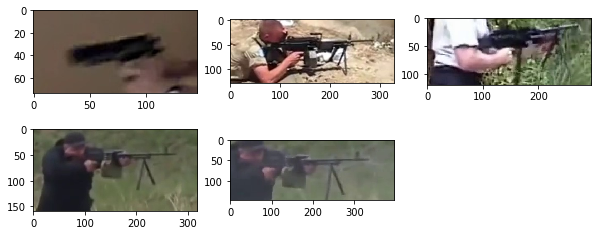



		Gun detections for bottom_5 confidence scores:		


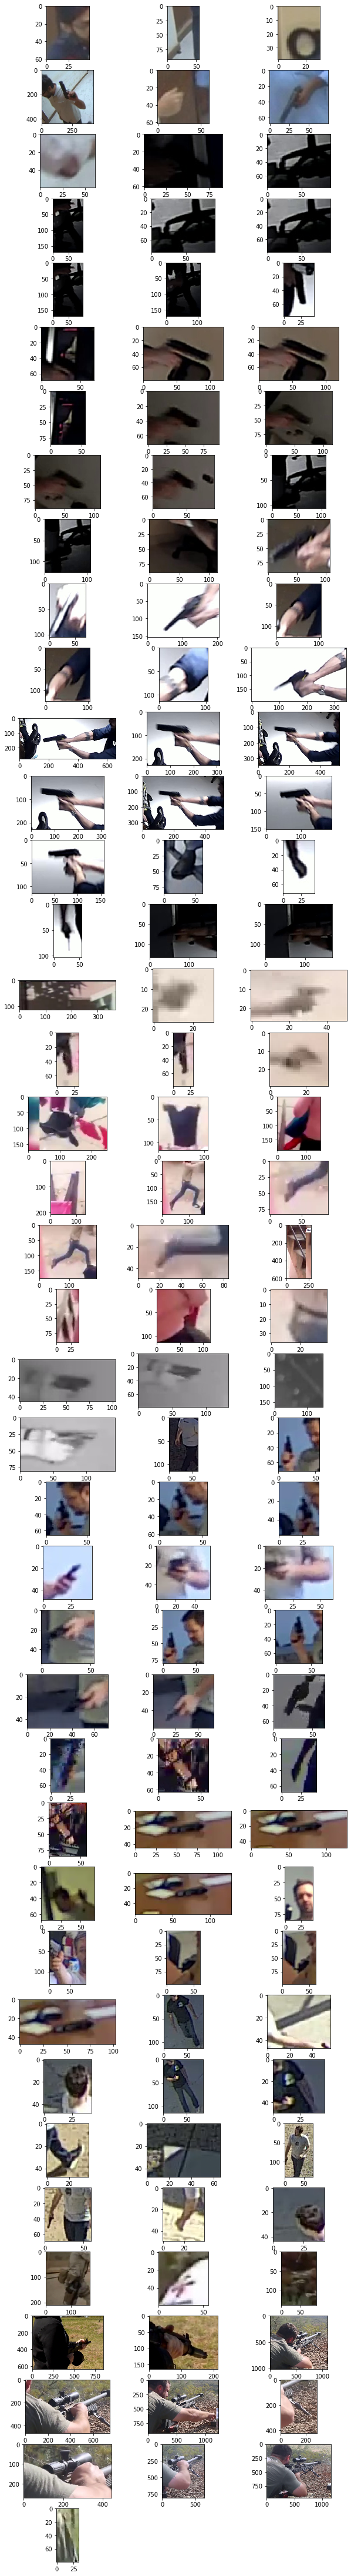



		Gun detections for mid_5 confidence scores:		


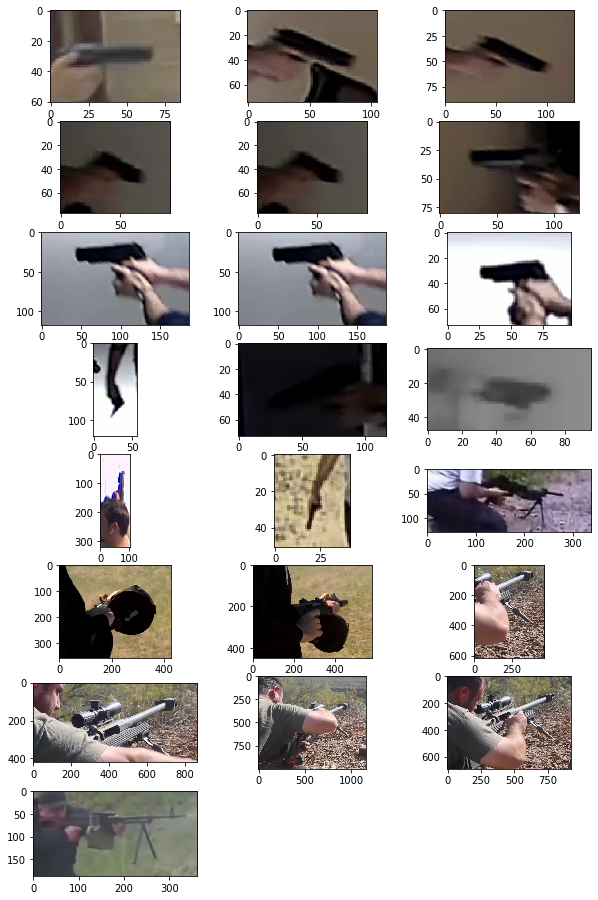

In [11]:
# Iterate over each top5, bot5 and mid5
for action in actions:
    print(f'\n\n\t\tGun detections for {action} confidence scores:\t\t')
    action_folder = output_images_folder + action
    if not os.path.exists(action_folder):
        os.makedirs(action_folder)

    # subset dataframe by confidence range
    df_sub = df.loc[df['confidence'].isin(actions[action])]

    df_gun = df_sub[df_sub["label"] == "gun"]
    n_images = len(df_gun)
    n_cols = 3
    n_rows = int(n_images/n_cols)+1
    i = 0
    fig=plt.figure(figsize=(10, n_rows*2))
    for n, row in df_gun.iterrows():
        i+=1
        label = row.label
        if label != "gun":
            continue
        conf = row.confidence
        # read each image from subset dataframe
        img = cv2.imread(row.file_path)
        x1, y1, x2, y2 = add_bbox_padding(row.coords, img.shape, pad=1.25)

        # crop and save in resepective folder
        img = img[y1:y2, x1:x2]
        fig.add_subplot(n_rows, n_cols, i)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

        # filename is "confidence_rowNumber"
#         cv2.imwrite(action_folder+"/"+str(conf)+"_"+str(n)+".jpg", img)
#         print(img.shape)
#         plt.figure(figsize=(img.shape[0],img.shape[1]))
#         plt.imshow(img)


### Tensorboard graphs

In [16]:
%load_ext tensorboard
logs_base_dir = "./runs"
os.makedirs(logs_base_dir, exist_ok=True)
%tensorboard --logdir {logs_base_dir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 19599), started 0:05:25 ago. (Use '!kill 19599' to kill it.)

## Class-wise evaluation

#### Confidence threshold = 0.1

In [19]:
!python test.py --data ./grand_test/onestage.data --cfg ./grand_train/cfg/one_stage.cfg --weights ./grand_train/weights/best.pt --conf-thres 0.1

Namespace(batch_size=16, cfg='./grand_train/cfg/one_stage.cfg', conf_thres=0.1, data='./grand_test/onestage.data', device='', img_size=416, iou_thres=0.5, nms_thres=0.5, save_json=False, weights='./grand_train/weights/best.pt')
Using CUDA device0 _CudaDeviceProperties(name='GeForce RTX 2080', total_memory=7979MB)

Reading image shapes: 100%|████████████████| 521/521 [00:00<00:00, 15355.65it/s]
               Class    Images   Targets         P         R   mAP@0.5        F1: 100%|█| 33/33 [00:05<00:00,  6.15it/s]
                 all       521  1.32e+03     0.525     0.588     0.525     0.554
              person       521       810     0.628     0.757     0.701     0.686
                 gun       521       507     0.423      0.42     0.349     0.421


#### Confidence threshold = 0.3

In [20]:
!python test.py --data ./grand_test/onestage.data --cfg ./grand_train/cfg/one_stage.cfg --weights ./grand_train/weights/best.pt --conf-thres 0.3

Namespace(batch_size=16, cfg='./grand_train/cfg/one_stage.cfg', conf_thres=0.3, data='./grand_test/onestage.data', device='', img_size=416, iou_thres=0.5, nms_thres=0.5, save_json=False, weights='./grand_train/weights/best.pt')
Using CUDA device0 _CudaDeviceProperties(name='GeForce RTX 2080', total_memory=7979MB)

               Class    Images   Targets         P         R   mAP@0.5        F1: 100%|█| 33/33 [00:04<00:00,  7.08it/s]
                 all       521  1.32e+03     0.759     0.501     0.468     0.588
              person       521       810     0.792     0.681      0.65     0.733
                 gun       521       507     0.726      0.32     0.287     0.444


#### Confidence threshold = 0.5

In [21]:
!python test.py --data ./grand_test/onestage.data --cfg ./grand_train/cfg/one_stage.cfg --weights ./grand_train/weights/best.pt --conf-thres 0.5

Namespace(batch_size=16, cfg='./grand_train/cfg/one_stage.cfg', conf_thres=0.5, data='./grand_test/onestage.data', device='', img_size=416, iou_thres=0.5, nms_thres=0.5, save_json=False, weights='./grand_train/weights/best.pt')
Using CUDA device0 _CudaDeviceProperties(name='GeForce RTX 2080', total_memory=7979MB)

               Class    Images   Targets         P         R   mAP@0.5        F1: 100%|█| 33/33 [00:04<00:00,  7.37it/s]
                 all       521  1.32e+03     0.857     0.427     0.406     0.538
              person       521       810     0.873     0.644     0.617     0.741
                 gun       521       507     0.841     0.209     0.194     0.335


In [ ]:
# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--cfg', type=str, default='/home/rahi/darvis/gun_detection/yolov3/cfg/one_stage.cfg', help='cfg file path')
#     parser.add_argument('--data', type=str, default='/home/rahi/darvis/gun_detection/yolov3/exp_scratch/grand_train/onestage.data', help='coco.data file path')
#     parser.add_argument('--weights', type=str, default='/home/rahi/darvis/gun_detection/yolov3/weights_grand_train/best.pt', help='path to weights file')
#     parser.add_argument('--source', type=str, default='/home/rahi/darvis/gun_detection/exp_scratch/grand_test_data/images/', help='source')  # input file/folder, 0 for webcam
#     parser.add_argument('--output', type=str, default='./inference_analysis/detections/model_detections/', help='output folder')  # output folder
#     parser.add_argument('--img-size', type=int, default=416, help='inference size (pixels)')
#     parser.add_argument('--conf-thres', type=float, default=0.1, help='object confidence threshold')
#     parser.add_argument('--nms-thres', type=float, default=0.5, help='iou threshold for non-maximum suppression')
#     parser.add_argument('--fourcc', type=str, default='mp4v', help='output video codec (verify ffmpeg support)')
#     parser.add_argument('--half', action='store_true', help='half precision FP16 inference')
#     parser.add_argument('--device', default='', help='device id (i.e. 0 or 0,1) or cpu')
#     parser.add_argument('--view-img', action='store_true', help='display results')
#     opt = parser.parse_args()
#     print(opt)

#     with torch.no_grad():
#         inferences = detect()
#         from pprint import pprint
#         print(f'\tOutput Result:\t')
#         pprint(inferences)